In [1]:
# # you will be prompted with a window asking to grant permissions
# !pip install google
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
# # fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
# import os
# datadir = "/content/assignment4"
# if not os.path.exists(datadir):
#   !ln -s "/content/drive/MyDrive/MP4/" $datadir # TODO: Fill your Assignment 4 path
# os.chdir(datadir)
# !pwd

In [3]:
# # NOTE: Loading data from Google Drive is VERY SLOW. Therefore, we download the data to a local storage
# # specified by VOC_PATH.
# # This means the data would have be re-downloaded everytime.
# # Change this path if you are running this script locally
# # VOC_PATH="/content/VOC_DATA"
# VOC_PATH = "/Users/sulvwei/Desktop"

# !chmod u+x ./download_data.sh
# !sed -i 's/\r//g' ./download_data.sh
# !cat ./download_data.sh
# !bash ./download_data.sh $VOC_PATH

In [3]:

import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader

from src.resnet_yolo import resnet50
import yolo_loss
from src.dataset import CocoYoloTxtDataset
from src.predict import predict_image
from src.config import COCO_CLASSES, COLORS

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

## **Start from here if you modified yolo_loss.py and wish to retrain**

In [7]:
# We recommend tuning only the batch size; the remaining hyperparameters should work well
# with the default values. However, you are free to experiment with them.

learning_rate = 0.002
num_epochs = 10
batch_size = 16

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [8]:
# COCO_PATH = os.path.join(os.getcwd(), "final_project")
# annotation_file_train = 'data/voc2007.txt'

# train_dataset = CocoYoloTxtDataset(
#     root_dir=COCO_PATH,   # this should point to the folder containing 'images/' and 'labels/'
#     split="train2017",          # subfolder name under images/ and labels/
#     S=S,                        # grid size (e.g., 14 or 7)
#     preproc=True,               # enable data augmentation
#     return_image_id=False,
#     encode_target=True
# )

# train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
# print('Loaded %d train images' % len(train_dataset))
COCO_PATH = os.path.join(os.getcwd())
S = 14  # example grid size, adjust for your YOLO version
batch_size = 16  # example batch size

train_dataset = CocoYoloTxtDataset(
    root_dir=COCO_PATH,      # contains images/ and labels/
    split="train2017",       # subfolder name
    S=S,
    preproc=True,
    return_image_id=False,
    encode_target=True
)

# 4️⃣ Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing COCO (YOLO-txt) dataset split=train2017
Loaded 118287 train images


In [10]:
# file_root_test = os.path.join(VOC_PATH, 'VOCdevkit_2007/VOC2007test/JPEGImages/')
# annotation_file_test = 'data/voc2007test.txt'

# test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
# test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
# print('Loaded %d test images' % len(test_dataset))
test_dataset = CocoYoloTxtDataset(
    root_dir=COCO_PATH,         # folder containing 'images/' and 'labels/'
    split="val2017",            # use val2017 for testing
    S=S,
    preproc=False,              # no random augmentation during testing
    return_image_id=False,       # helpful for evaluation
    encode_target=True
)

# 3️⃣ DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print("Loaded %d test images" % len(test_dataset))

Initializing COCO (YOLO-txt) dataset split=val2017
Loaded 5000 test images


In [11]:
data = train_dataset[0]

## Initializing the network

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [ ]:
torch.cuda.empty_cache()

In [12]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


## Set up training tools

In [13]:
from importlib import reload
reload(yolo_loss) # update the import if the implementation has changed

criterion = yolo_loss.YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [10]:
import os, tempfile, time, torch

def safe_save_state_dict(state_dict, path, use_legacy=True, retries=3):
    """Save via temp file then atomic replace; legacy serializer avoids inline_container issues on Windows."""
    d = os.path.dirname(os.path.abspath(path))
    os.makedirs(d, exist_ok=True)
    fd, tmp = tempfile.mkstemp(prefix=".tmp_ckpt_", dir=d)
    os.close(fd)
    last_err = None
    for k in range(retries):
        try:
            # legacy (non-zip) format:
            torch.save(state_dict, tmp, _use_new_zipfile_serialization=not use_legacy if use_legacy is not None else True)
            os.replace(tmp, path)  # atomic overwrite
            return
        except Exception as e:
            last_err = e
            time.sleep(0.25 * (k + 1))
    try:
        if os.path.exists(tmp): os.remove(tmp)
    except Exception:
        pass
    raise last_err


In [49]:
# best_test_loss = np.inf
# learning_rate = learning_rate

# os.makedirs('./checkpoints', exist_ok=True)
# for epoch in range(num_epochs):
#     net.train()

#     # Update learning rate late in training
#     if epoch == 30 or epoch == 40:
#         learning_rate /= 10.0

#     for param_group in optimizer.param_groups:
#         param_group['lr'] = learning_rate

#     print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
#     print('Learning Rate for this epoch: {}'.format(learning_rate))

#     total_loss = collections.defaultdict(int)

#     for i, data in enumerate(train_loader):
#         data = (item.to(device) for item in data)
#         images, target_boxes, target_cls, has_object_map = data
#         pred = net(images)
#         loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
#         for key in loss_dict:
#             total_loss[key] += loss_dict[key].item()

#         optimizer.zero_grad()
#         loss_dict['total_loss'].backward()
#         optimizer.step()

#         if (i+1) % 50 == 0:
#             outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
#             outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
#             print(outstring)

#     # evaluate the network on the test data
#     if (epoch + 1) % 5 == 0:
#         test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
#         print(epoch, test_aps)
#     with torch.no_grad():
#         test_loss = 0.0
#         net.eval()
#         for i, data in enumerate(test_loader):
#             data = (item.to(device) for item in data)
#             images, target_boxes, target_cls, has_object_map = data

#             pred = net(images)
#             loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
#             test_loss += loss_dict['total_loss'].item()
#         test_loss /= len(test_loader)

#     if best_test_loss > test_loss:
#         best_test_loss = test_loss
#         print('Updating best test loss: %.5f' % best_test_loss)
#         torch.save(net.state_dict(),'checkpoints/best_detector.pth')

#     if (epoch+1) in [5, 10, 20, 30, 40]:
#         torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

#     torch.save(net.state_dict(),'checkpoints/detector.pth')

import os, collections, numpy as np
import torch
from torch.utils.data import DataLoader

# --- setup ---
best_test_loss = float("inf")

# optional: use a proper scheduler instead of manual if/else
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)

os.makedirs("./checkpoints", exist_ok=True)

for epoch in range(num_epochs):
    net.train()

    # keep your simple decay logic (or comment out if using scheduler)
    if epoch in (30, 40):
        for g in optimizer.param_groups:
            g["lr"] *= 0.1

    # (print the current LR from optimizer to avoid desync with a shadow variable)
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"\n\nStarting epoch {epoch+1} / {num_epochs}")
    print(f"Learning Rate for this epoch: {current_lr}")

    total_loss = collections.defaultdict(float)

    # --------- TRAIN LOOP ---------
    for i, (images, target_boxes, target_cls, has_object_map) in enumerate(train_loader):

        images = images.to(device, non_blocking=True)
        target_boxes = target_boxes.to(device, non_blocking=True)
        target_cls = target_cls.to(device, non_blocking=True)
        has_object_map = has_object_map.to(device, non_blocking=True)

        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)

        optimizer.zero_grad(set_to_none=True)
        loss_dict["total_loss"].backward()
        optimizer.step()

        for k, v in loss_dict.items():
            total_loss[k] += float(v.detach())

        if (i + 1) % 50 == 0:
            avg = ", ".join(f"{k[:-5]}={v / (i + 1):.3f}" for k, v in total_loss.items())
            print(f"Epoch [{epoch+1}/{num_epochs}], Iter [{i+1}/{len(train_loader)}], Loss: {avg}")

    # if you enabled a scheduler above:
    # scheduler.step()

    # --------- VAL/TEST LOSS (using test_loader directly) ---------
    net.eval()
    with torch.no_grad():
        test_loss = 0.0
        for images, target_boxes, target_cls, has_object_map in test_loader:
            images = images.to(device, non_blocking=True)
            target_boxes = target_boxes.to(device, non_blocking=True)
            target_cls = target_cls.to(device, non_blocking=True)
            has_object_map = has_object_map.to(device, non_blocking=True)

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += float(loss_dict["total_loss"])

        test_loss /= max(1, len(test_loader))
        print(f"Validation loss: {test_loss:.5f}")

    # --------- CHECKPOINTING ---------
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print(f"Updating best test loss: {best_test_loss:.5f}")
        safe_save_state_dict(net.state_dict(), "checkpoints/best_detector.pth", use_legacy=True)

    if (epoch + 1) in [5, 10, 20, 30, 40]:
        safe_save_state_dict(net.state_dict(), f"checkpoints/detector_epoch_{epoch+1}.pth", use_legacy=True)

    safe_save_state_dict(net.state_dict(), "checkpoints/detector.pth", use_legacy=True)




Starting epoch 1 / 6
Learning Rate for this epoch: 0.002


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 121.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
import os, glob, time

for p in sorted(glob.glob("checkpoints/*.pth")):
    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(os.path.getmtime(p))), "  ", p, "  ", os.path.getsize(p)//1024, "KB")


2025-11-13 03:03:05    checkpoints\best.pth    105242 KB
2025-11-13 03:03:05    checkpoints\detector.pth    105242 KB
2025-11-12 22:47:44    checkpoints\detector_epoch_10.pth    105242 KB
2025-11-13 00:29:32    checkpoints\detector_epoch_12.pth    105242 KB
2025-11-13 02:12:04    checkpoints\detector_epoch_14.pth    105242 KB
2025-11-12 02:36:33    checkpoints\detector_epoch_5.pth    105242 KB
2025-11-12 19:26:03    checkpoints\detector_epoch_6.pth    105242 KB
2025-11-12 21:06:33    checkpoints\detector_epoch_8.pth    105242 KB


In [17]:
num_epochs = 10
# learning_rate = 0.0002
ckpt_path = r"checkpoints\best2.pth"  # or best_detector.pth
state = torch.load(ckpt_path, map_location=device)
net.load_state_dict(state, strict=True)  # strict=True if you’re sure it matches exactly
best_test_loss = float("inf")

# optional: use a proper scheduler instead of manual if/else
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)

os.makedirs("./checkpoints", exist_ok=True)

start_epoch = 1  # resume from 6 (or set to 6 again to redo that epoch)
for epoch in range(start_epoch, start_epoch+num_epochs):
    net.train()

    # keep your simple decay logic (or comment out if using scheduler)
    if epoch in (30, 40):
        for g in optimizer.param_groups:
            g["lr"] *= 0.1

    # (print the current LR from optimizer to avoid desync with a shadow variable)
    current_lr = optimizer.param_groups[0]["lr"]
    current_lr /= 10
    print(f"\n\nStarting epoch {epoch+1} / {num_epochs}")
    print(f"Learning Rate for this epoch: {current_lr}")

    total_loss = collections.defaultdict(float)

    # --------- TRAIN LOOP ---------
    for i, (images, target_boxes, target_cls, has_object_map) in enumerate(train_loader):
        # print("cp1")
        images = images.to(device, non_blocking=True)
        target_boxes = target_boxes.to(device, non_blocking=True)
        target_cls = target_cls.to(device, non_blocking=True)
        has_object_map = has_object_map.to(device, non_blocking=True)
        # print("cp2")
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        # print("cp3")
        optimizer.zero_grad(set_to_none=True)
        loss_dict["total_loss"].backward()
        optimizer.step()
        # print("cp4")
        for k, v in loss_dict.items():
            total_loss[k] += float(v.detach())

        if (i + 1) % 50 == 0:
            avg = ", ".join(f"{k[:-5]}={v / (i + 1):.3f}" for k, v in total_loss.items())
            print(f"Epoch [{epoch+1}/{num_epochs}], Iter [{i+1}/{len(train_loader)}], Loss: {avg}")

    # if you enabled a scheduler above:
    # scheduler.step()

    # --------- VAL/TEST LOSS (using test_loader directly) ---------
    net.eval()
    with torch.no_grad():
        test_loss = 0.0
        for images, target_boxes, target_cls, has_object_map in test_loader:
            images = images.to(device, non_blocking=True)
            target_boxes = target_boxes.to(device, non_blocking=True)
            target_cls = target_cls.to(device, non_blocking=True)
            has_object_map = has_object_map.to(device, non_blocking=True)

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += float(loss_dict["total_loss"])

        test_loss /= max(1, len(test_loader))
        print(f"Validation loss: {test_loss:.5f}")

    # --------- CHECKPOINTING ---------
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print(f"Updating best test loss: {best_test_loss:.5f}")
        safe_save_state_dict(net.state_dict(), "checkpoints/best_detector.pth", use_legacy=True)

    if True:
        safe_save_state_dict(net.state_dict(), f"checkpoints/detector_epoch_{epoch+1}.pth", use_legacy=True)

    safe_save_state_dict(net.state_dict(), "checkpoints/detector.pth", use_legacy=True)



C:\Users\Liangcheng Sun\AppData\Local\Temp\ipykernel_29820\4197881073.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)




Starting epoch 2 / 10
Learning Rate for this epoch: 0.0002
Epoch [2/10], Iter [50/7393], Loss: total=5.992, reg=2.556, containing_obj=0.983, no_obj=0.330, cls=2.124
Epoch [2/10], Iter [100/7393], Loss: total=5.743, reg=2.439, containing_obj=0.937, no_obj=0.331, cls=2.036
Epoch [2/10], Iter [150/7393], Loss: total=5.724, reg=2.443, containing_obj=0.916, no_obj=0.322, cls=2.044
Epoch [2/10], Iter [200/7393], Loss: total=5.679, reg=2.409, containing_obj=0.911, no_obj=0.317, cls=2.042
Epoch [2/10], Iter [250/7393], Loss: total=5.674, reg=2.404, containing_obj=0.913, no_obj=0.312, cls=2.045
Epoch [2/10], Iter [300/7393], Loss: total=5.693, reg=2.409, containing_obj=0.915, no_obj=0.310, cls=2.059
Epoch [2/10], Iter [350/7393], Loss: total=5.689, reg=2.399, containing_obj=0.918, no_obj=0.310, cls=2.062
Epoch [2/10], Iter [400/7393], Loss: total=5.664, reg=2.389, containing_obj=0.918, no_obj=0.309, cls=2.048
Epoch [2/10], Iter [450/7393], Loss: total=5.675, reg=2.396, containing_obj=0.919, n

KeyboardInterrupt: 

In [18]:
import os, torch
from collections import OrderedDict

# 0) Make sure 'net' is already built EXACTLY like training
net.to(device)

ckpt_path = r"checkpoints\best.pth"   # <- your renamed file
assert os.path.isfile(ckpt_path), f"Not found: {ckpt_path}"

# 1) Load checkpoint to current device
ckpt = torch.load(ckpt_path, map_location=device)

# 2) Get state_dict (handle both formats)
state = ckpt.get("state_dict", ckpt)

# 3) Strip 'module.' if present
clean_state = OrderedDict()
for k, v in state.items():
    nk = k[7:] if k.startswith("module.") else k
    clean_state[nk] = v

# 4) If weights were saved in FP16 but your model is FP32, upcast
#    (skip this if you intentionally run half precision and do net.half())
for k, v in list(clean_state.items()):
    if torch.is_tensor(v) and v.dtype == torch.float16 and next(net.parameters()).dtype == torch.float32:
        clean_state[k] = v.float()

# 5) Load (non-strict fallback is helpful if buffers/names differ slightly)
try:
    net.load_state_dict(clean_state, strict=True)
except RuntimeError as e:
    print(f"[warn] strict load failed ({e}); trying non-strict…")
    net.load_state_dict(clean_state, strict=False)

net.eval()


C:\Users\Liangcheng Sun\AppData\Local\Temp\ipykernel_25880\196432580.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# View example predictions

predicting...
Saved to: output3.jpg


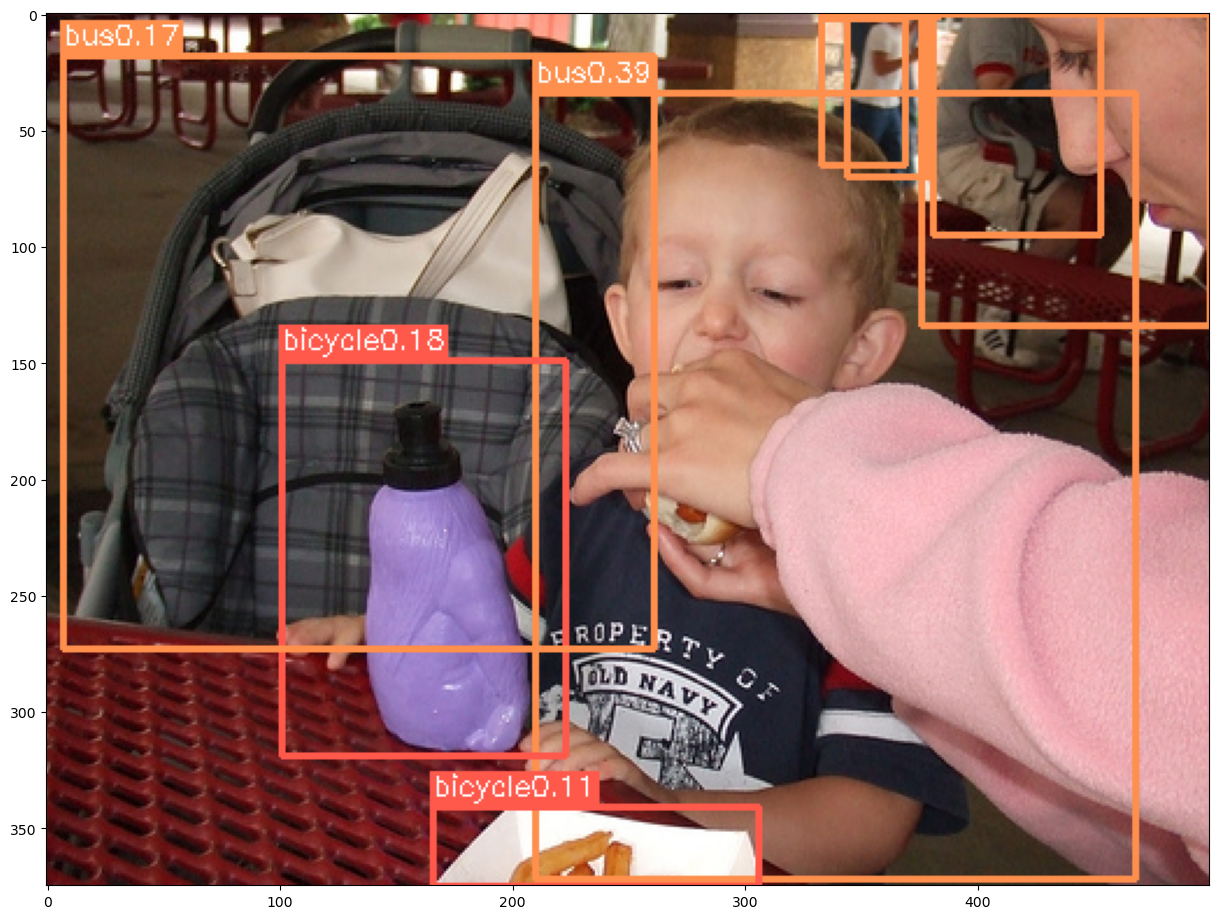

In [21]:
from src.predict import predict_image
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
file_root_test = r"C:\Users\Liangcheng Sun\Desktop\543\final_project\images"

image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[COCO_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)
save_path = "output3.jpg"   # choose any path you like

# convert RGB back to BGR for saving
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imwrite(save_path, image_bgr)

print("Saved to:", save_path)



## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [25]:
from src.eval_voc import evaluate_coco_yolo_txt
test_aps = evaluate_coco_yolo_txt(
    net,
    root_dir=COCO_PATH,
    split="val2017",      # or "train2017" if you want train eval
    iou_threshold=0.5,
    max_images=None       # or a small int for a quick check, e.g., 200
)

100%|██████████| 5000/5000 [01:44<00:00, 48.02it/s]

---Evaluate model on test samples---



  0%|          | 4/5000 [00:02<53:33,  1.55it/s]  


IndexError: tuple index out of range

### Cell added to get intermediate mAP values for students

In [22]:
network_paths = [f'./checkpoints/detector_epoch_{epoch}.pth' for epoch in [5, 10, 20, 30, 40]] + [
    './checkpoints/detector.pth'
]

COCO_PATH = r"C:\Users\Liangcheng Sun\Desktop\543\final_project"   # folder that has images/ and labels/
SPLIT = "val2017"

for ckpt in network_paths:
    if not os.path.exists(ckpt):
        print(f"[skip] Checkpoint not found: {ckpt}")
        continue

    print(f"Loading saved network from {ckpt}")
    net_loaded = resnet50().to(device)
    # robust load: map to current device; allow dtype/half-precision
    state = torch.load(ckpt, map_location=device)
    try:
        net_loaded.load_state_dict(state, strict=True)
    except RuntimeError as e:
        print(f"[warn] strict load failed ({e}); trying non-strict…")
        net_loaded.load_state_dict(state, strict=False)

    net_loaded.eval()
    aps = evaluate_coco_yolo_txt(
        net_loaded,
        root_dir=COCO_PATH,   # MUST be the dir containing images/ and labels/
        split=SPLIT,
        iou_threshold=0.5,
        # max_images=200,     # uncomment to evaluate a subset quickly
    )
    print(f"mAP@0.5 = {sum(aps)/len(aps):.4f}")


Loading saved network from ./checkpoints/detector_epoch_5.pth


C:\Users\Liangcheng Sun\AppData\Local\Temp\ipykernel_19180\1317282303.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt, map_location=device)


100%|██████████| 128/128 [00:00<00:00, 588.06it/s]

---Evaluate model on test samples---



100%|██████████| 128/128 [00:02<00:00, 47.76it/s]


--- mAP@0.50: 0.0000 ---
mAP@0.5 = 0.0000
Loading saved network from ./checkpoints/detector_epoch_10.pth


100%|██████████| 128/128 [00:00<00:00, 754.11it/s]

---Evaluate model on test samples---



100%|██████████| 128/128 [00:01<00:00, 64.18it/s]


--- mAP@0.50: 0.0000 ---
mAP@0.5 = 0.0000
Loading saved network from ./checkpoints/detector_epoch_20.pth


100%|██████████| 128/128 [00:00<00:00, 781.18it/s]

---Evaluate model on test samples---



100%|██████████| 128/128 [00:02<00:00, 62.65it/s]


--- mAP@0.50: 0.0000 ---
mAP@0.5 = 0.0000
Loading saved network from ./checkpoints/detector_epoch_30.pth


100%|██████████| 128/128 [00:00<00:00, 774.20it/s]

---Evaluate model on test samples---



100%|██████████| 128/128 [00:02<00:00, 62.68it/s]


--- mAP@0.50: 0.0000 ---
mAP@0.5 = 0.0000
Loading saved network from ./checkpoints/detector_epoch_40.pth


100%|██████████| 128/128 [00:00<00:00, 748.65it/s]

---Evaluate model on test samples---



100%|██████████| 128/128 [00:01<00:00, 65.91it/s]


--- mAP@0.50: 0.0000 ---
mAP@0.5 = 0.0000
Loading saved network from ./checkpoints/detector.pth


100%|██████████| 128/128 [00:00<00:00, 766.90it/s]

---Evaluate model on test samples---



100%|██████████| 128/128 [00:05<00:00, 22.15it/s]

--- mAP@0.50: 0.0000 ---
mAP@0.5 = 0.0000
